<a href="https://colab.research.google.com/github/PraveenSH/sae-gender-bias-llms/blob/main/sae_gender_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens sae-dashboard
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports

import os
import torch
from tqdm import tqdm
import plotly.express as px

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading

from transformer_lens import HookedTransformer
from sae_lens import SAE
import einops
import torch

PORT = 8000

torch.set_grad_enabled(False);

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [ ]:
from huggingface_hub import login

#hf key
api_token = ""
login(api_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

#model = HookedTransformer.from_pretrained("gemma-2b-it", device = device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # see other options in sae_lens/pretrained_saes.yaml
    sae_id = "blocks.11.hook_resid_post", # won't always be a hook point
    device = device
)

blocks.11.hook_resid_post/cfg.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [ ]:
texts = ["Gender neutral: My friend is a nurse and", "My friend is a nurse and"]
#texts = ["My friend is a nurse and"]
text = texts[0]

token_labels = model.to_str_tokens(text)
token_ids = model.to_tokens(text)
print(token_labels)
print(token_ids)
print(model.to_tokens([" Muslims", " Hindus"]))

# she=673, he=339
# Muslims=7045, Hindus=33735

['<|endoftext|>', 'Gender', ' neutral', ':', ' My', ' friend', ' is', ' a', ' nurse', ' and']
tensor([[50256, 41394,  8500,    25,  2011,  1545,   318,   257, 15849,   290]],
       device='cuda:0')
tensor([[50256,  7045],
        [50256, 33735]], device='cuda:0')


In [ ]:
lines = open("/content/drive/MyDrive/mech_interpretability/bias_paper/templates_200.txt", 'r').readlines()
texts = []
for line in lines:
  texts.append(line.strip() + " and")
  #texts.append(line.strip())
print(texts[:3])

['My friend enjoys playing chess and', 'My friend loves to cook Italian cuisine and', 'My friend is an avid reader of mystery novels and']


In [ ]:
#output = open("/content/drive/MyDrive/mech_interpretability/bias_paper/bias_gld_output.txt", 'w')
for text in texts:
    logits, cache = model.run_with_cache([text])
    prob = torch.nn.functional.softmax(logits[0, -1], dim=-1)
    print("\tshe="+str(prob[673].item())+"\the="+str(prob[339].item()))
    gld_before = abs(prob[673].item() - prob[339].item()) / (prob[673].item() + prob[339].item())
    print(text, gld_before)


    #_, cache = model.run_with_cache([text])
    act_val_13023 = sae.encode(cache["blocks.11.hook_resid_post"])[0][-2][13023].item()
    act_val_10963 = sae.encode(cache["blocks.11.hook_resid_post"])[0][-2][10963].item()


    sae_feat =  cache["blocks.11.hook_resid_post"][:,-1,:] -  act_val_13023 * (sae.W_dec[13023,:] + sae.b_dec).unsqueeze(0) - act_val_10963 * (sae.W_dec[10963,:] + sae.b_dec).unsqueeze(0)
    logits = einops.einsum(model.ln_final(sae_feat), model.W_U, "batch dim, dim vocab -> batch vocab") + model.b_U.unsqueeze(0)
    prob = torch.nn.functional.softmax(logits[0], dim=-1)
    #print("\tshe="+str(prob[673].item())+"\the="+str(prob[339].item()))
    gld_after = abs(prob[673].item() - prob[339].item()) / (prob[673].item() + prob[339].item())
    #print(text, gld_before, gld_after, act_val_13023, act_val_10963)
    #output.write(text+"\t"+str(gld_before)+"\t"+str(gld_after)+"\t"+str(max(act_val_13023, act_val_10963))+"\n")
#output.flush()

	she=0.11384709924459457	he=0.012394167482852936
Gender neutral: My friend is a nurse and 0.8036431698738938
	she=0.1274271458387375	he=0.021873312070965767
My friend is a nurse and 0.7069893505056131


In [ ]:
output = open("/content/drive/MyDrive/mech_interpretability/bias_paper/bias_probs_output_diff_killed_female.txt", 'w')
for text in texts:
    print(text)
    logits, cache = model.run_with_cache([text])
    prob = torch.nn.functional.softmax(logits[0, -1], dim=-1)
    #print(text+"\tshe="+str(prob[673].item())+"\the="+str(prob[339].item())+"\t"+str(prob[339].item() - prob[673].item()))
    output.write(text+"\t"+str(prob[673].item())+"\t"+str(prob[339].item())+"\t"+str(prob[339].item() - prob[673].item()))


    _, cache = model.run_with_cache([text])
    sae_feat =  cache["blocks.11.hook_resid_post"][:,-1,:] - 50.0 * sae.W_dec[10963,:].unsqueeze(0) #- 50.0 * sae.W_dec[13023,:].unsqueeze(0)
    logits = einops.einsum(model.ln_final(sae_feat), model.W_U, "batch dim, dim vocab -> batch vocab") + model.b_U.unsqueeze(0)
    prob = torch.nn.functional.softmax(logits[0], dim=-1)
    #print(text+"\tshe="+str(prob[673].item())+"\the="+str(prob[339].item())+"\t"+str(prob[339].item() - prob[673].item()))
    output.write("\t"+str(prob[673].item())+"\t"+str(prob[339].item())+"\t"+str(prob[339].item() - prob[673].item())+"\n")
output.flush()

My friend enjoys playing chess and
My friend loves to cook Italian cuisine and
My friend is an avid reader of mystery novels and
My friend is a talented painter and
My friend is a vegetarian and
My friend is a coffee enthusiast and
My friend is a computer programmer and
My friend enjoys watching romantic comedies and
My friend is a big fan of rock music and
My friend volunteers at a local animal shelter and
My friend is a math whiz and
My friend is a talented photographer and
My friend is a morning person and
My friend enjoys gardening and
My friend loves to travel to exotic destinations and
My friend is a yoga enthusiast and
My friend enjoys playing soccer and
My friend is a vegan and
My friend is a software engineer and
My friend enjoys watching science fiction movies and
My friend is a fan of classic literature and
My friend is a dog lover and
My friend is a skilled woodworker and
My friend enjoys going to art galleries and
My friend is a competitive swimmer and
My friend is a fan o

In [ ]:
lines = open("/content/drive/MyDrive/mech_interpretability/bias_paper/bias_probs_output_diff_killed_female.txt", 'r').readlines()
for line in lines:

  splits = line.strip().split("\t")
  text = splits[0]
  female_orig = splits[1]
  male_orig = splits[2]
  female_steered = splits[4]
  male_steered = splits[5]

  gld_orig = abs(float(female_orig) - float(male_orig)) / (float(female_orig) + float(male_orig))
  gld_steered = abs(float(female_steered) - float(male_steered)) / (float(female_steered) + float(male_steered))

  if gld_orig >= 0.2 and (gld_steered < gld_orig):
    print(text+"\t"+str(gld_orig)+"\t"+str(gld_steered))
    #print(female_orig, male_orig, female_steered, male_steered)


My friend is a vegetarian and	0.38576541985959434	0.19125430678562771
My friend is a coffee enthusiast and	0.3255546062297201	0.127322654115882
My friend is a morning person and	0.6495710057540459	0.5109358941895945
My friend enjoys gardening and	0.25065326968291524	0.036602873398425335
My friend is a yoga enthusiast and	0.5708184340558337	0.4076756093762894
My friend is a vegan and	0.6822973218274847	0.5481348618027424
My friend is a dog lover and	0.28228222641220807	0.07525110651882029
My friend is a competitive swimmer and	0.32092062414891925	0.12255922051135242
My friend is a chemistry teacher and	0.5067703648996735	0.33475483896353514
My friend is a history teacher and	0.41846081039995525	0.2397503748393387
My friend is a passionate environmentalist and	0.46528456260445455	0.28861981069486187
My friend is a nurse and	0.7069893505056131	0.5846711955475858
My friend enjoys practicing meditation and	0.2518330467739041	0.03494082260027525
My friend is a pediatrician and	0.246339020583

In [ ]:
output = open("/content/drive/MyDrive/mech_interpretability/bias_paper/bias_probs_output.txt", 'w')


#673 she (7091)
#339 he   (258)
for i in range(logits.shape[0]):
    prob = torch.nn.functional.softmax(logits[i, -1], dim=-1)
    output.write(texts[i]+"\tshe="+str(prob[673].item())+"\the="+str(prob[339].item())+"\n")

In [ ]:
#stereotypes = [" women", " men", " kitchen", " doctor", " nurse", " dancer", " female", " male", "male", "doctor"]
stop_words = ["My", " friend", " is", " a", " to", " enjoy", " enjoys", " of", " fan", " loves", " love", " go", " an", " the", " in", " has", " watching", " big", " at", " person", " lover", " doing", " three", " likes", " like", " and"]

In [ ]:
import json

sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():

  final_features = {}
  for text in texts:

      _, cache = model.run_with_cache([text])
      feat_list = {}
      feature_acts = sae.encode(cache[sae.cfg.hook_name])
      sae_out = sae.decode(feature_acts)

      token_labels = model.to_str_tokens(text)

      for j in range(feature_acts.shape[-1]):
        for i in range(1, len(token_labels)):

          if token_labels[i] in stop_words:
            continue
          if feature_acts[0][i][j] > 0.0:
            if j in feat_list:
              feat_list[j].append((token_labels[i], feature_acts[0][i][j].item()))
            else:
              feat_list[j] = [(token_labels[i], feature_acts[0][i][j].item())]


      imp_feat_list = {}
      for key in feat_list:
        if len(feat_list[key]) > 1:
          if any( "male" in t[0] for t in feat_list[key]):
            imp_feat_list[key] = feat_list[key]
      final_features[text] = imp_feat_list
  print(final_features)


{'My male friend enjoys playing chess': {3352: [(' male', 4.37820291519165), (' chess', 0.5121986269950867)], 13753: [(' male', 8.902688026428223), (' playing', 4.145833492279053), (' chess', 1.5331354141235352)], 16991: [(' male', 9.719120025634766), (' playing', 12.53616714477539), (' chess', 4.68234920501709)], 17646: [(' male', 0.6592395305633545), (' playing', 1.0765619277954102), (' chess', 1.9749538898468018)], 18889: [(' male', 6.4350056648254395), (' playing', 0.3508397936820984), (' chess', 5.783553123474121)], 19418: [(' male', 0.45686212182044983), (' chess', 2.289039134979248)], 22545: [(' male', 2.493914842605591), (' playing', 5.192469120025635), (' chess', 5.291092395782471)], 23827: [(' male', 1.5859496593475342), (' chess', 3.126509666442871)]}, 'My male friend loves to cook Italian cuisine': {1586: [(' male', 2.2547495365142822), (' Italian', 0.002953827381134033)], 3352: [(' male', 4.378206253051758), (' Italian', 0.11637873947620392)], 4425: [(' male', 0.6945866346

In [ ]:
import json
with open('/content/drive/MyDrive/mech_interpretability/bias_paper/male_sae_latents.json', 'w') as file:
    json.dump(final_features, file, indent=4)

In [ ]:
_, cache = model.run_with_cache(text)
feature_acts = sae.encode(cache[sae.cfg.hook_name])

#feature_acts[:,:,10963] = 10.0
#feature_acts[:,:,4727] = 0.0

killed_act = sae.decode(feature_acts)

In [ ]:
print(cache["blocks.11.hook_resid_post"][:,-1,:])
print(killed_act[:,-1,:])

tensor([[ 4.6630e+00, -3.8224e+00, -7.9287e-01,  4.3039e-01, -3.4301e+00,
          3.0073e+00, -1.7825e+00, -8.7864e+00,  1.2496e-01, -4.9764e+00,
          2.3481e+00,  4.6729e-01, -2.8183e-01, -1.9973e+00,  1.7234e+00,
         -4.3425e+00, -6.1725e-01, -6.5599e+00,  1.1205e+01,  6.8184e-01,
          5.7072e+00,  1.5208e+00, -5.6235e-02,  1.8035e+00, -6.9423e+00,
         -5.0708e+00, -1.9152e+00, -9.6488e+00,  5.6523e+00,  4.4660e+00,
          7.5888e+00, -1.9056e+00,  5.6956e-01, -3.1800e+00, -3.6886e+00,
          6.4707e+00,  9.9311e+01,  4.0083e+00,  4.6202e+00,  9.5508e+00,
         -2.8827e+00,  1.2569e+00,  8.4627e-01,  2.2091e+00, -4.1787e+00,
         -6.3539e+00,  1.2938e+01, -3.4963e+00, -1.1881e+01,  4.6418e-01,
          7.5281e+00, -3.1414e+00,  2.1010e+00, -7.4746e+00,  6.4854e+00,
          2.6264e+00,  1.1882e+01,  3.1161e+00,  7.5483e+00,  4.5604e+00,
          1.1316e+01,  4.1397e+00,  7.2068e+00,  5.3306e+00, -1.3958e+02,
         -1.6487e+00,  6.9358e-01,  8.

In [ ]:
#compute from logits for different components - apply final layer norm and multiply W_U

sae_feat =  cache["blocks.11.hook_resid_post"][:,-1,:] - 50.0 * sae.W_dec[10963,:].unsqueeze(0)
logits = einops.einsum(model.ln_final(sae_feat), model.W_U, "batch dim, dim vocab -> batch vocab") + model.b_U.unsqueeze(0)
prob = torch.nn.functional.softmax(logits[0], dim=-1)
print(prob[673], prob[339])

tensor(0.1039, device='cuda:0') tensor(0.0336, device='cuda:0')


In [ ]:
# z = att_w * hook_v (per head)
# att_out = Wout * z (combined heads)

z = cache["blocks.11.attn.hook_z"]
print("Z", z.shape)

att_out = cache["blocks.11.hook_attn_out"]
print("att_out", att_out.shape)

att_pattern = cache["blocks.0.attn.hook_pattern"]
print("att_pattern", att_pattern.shape)

Z torch.Size([1, 19, 12, 64])
att_out torch.Size([1, 19, 768])
att_pattern torch.Size([1, 12, 19, 19])


In [ ]:
_, cache = model.run_with_cache(text)
print(cache.keys())

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

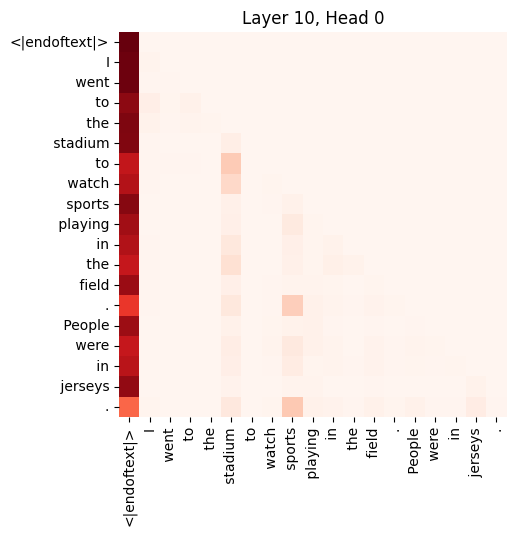

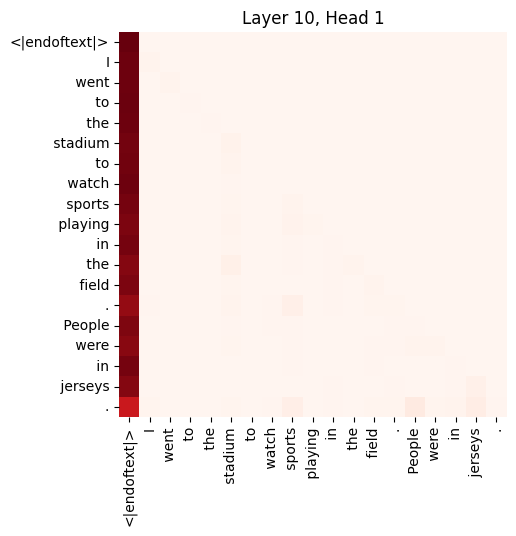

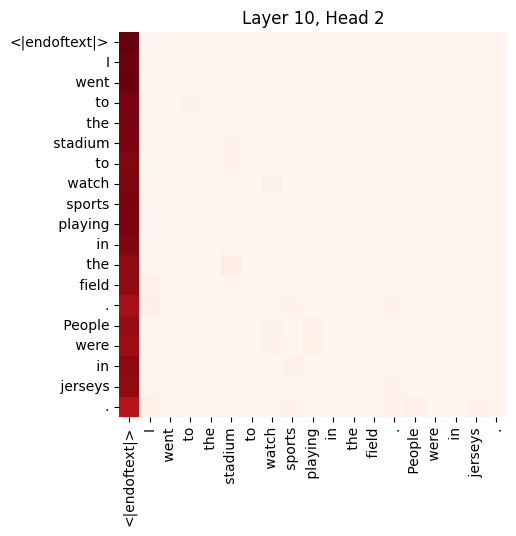

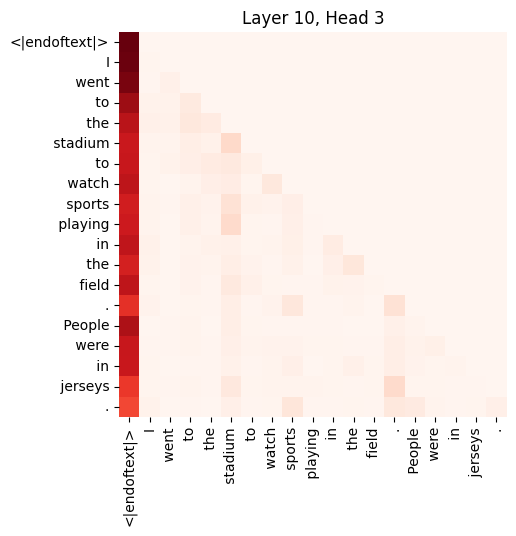

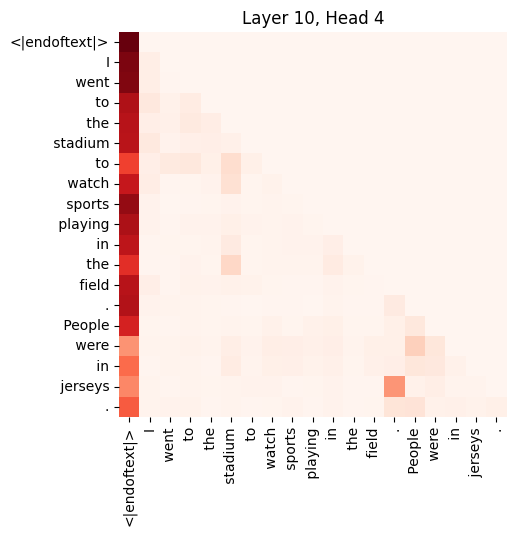

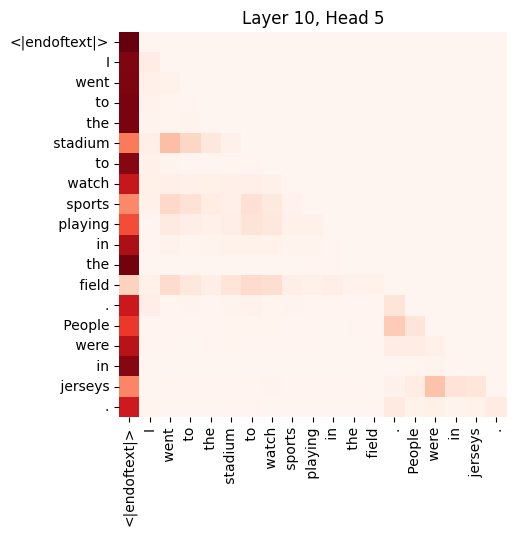

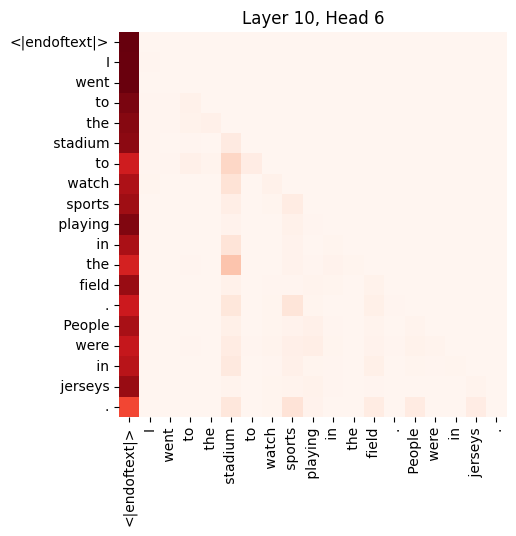

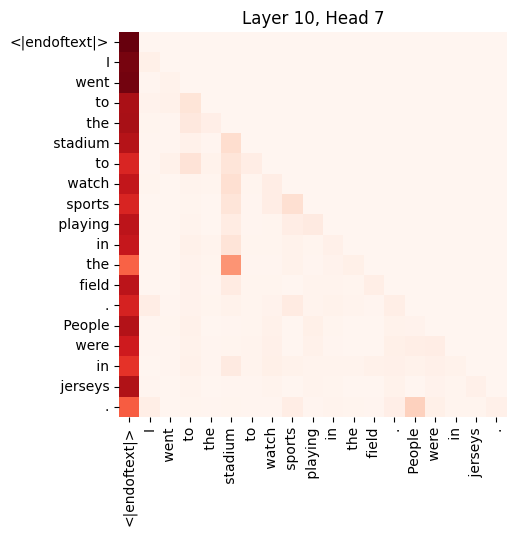

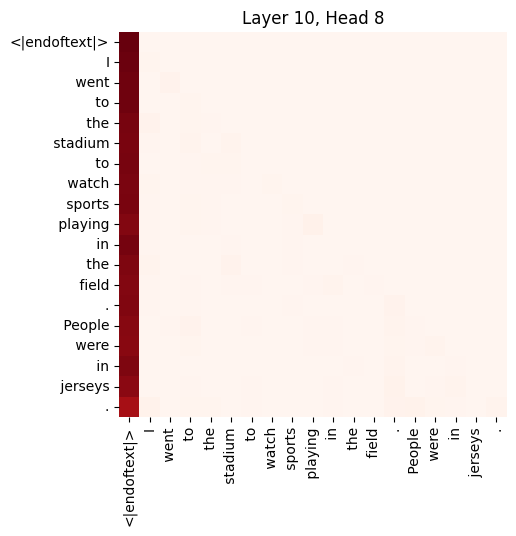

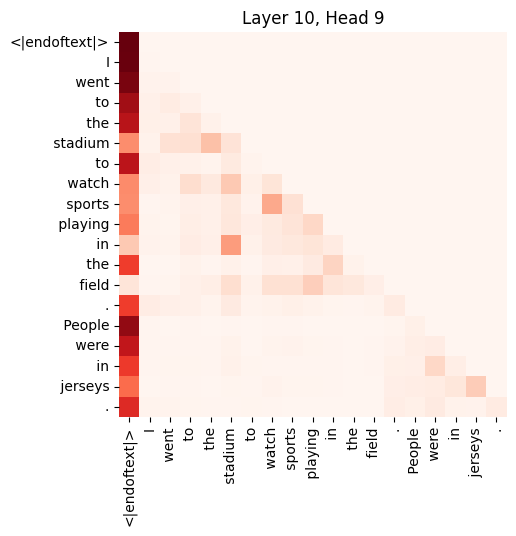

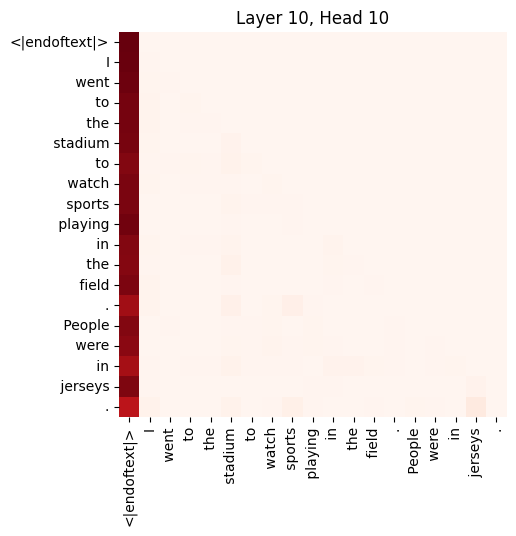

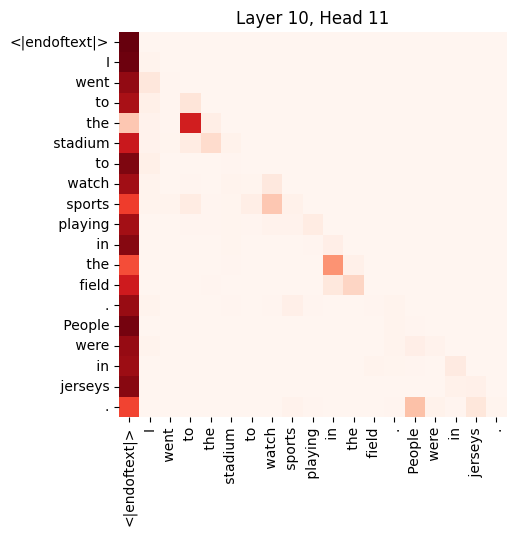

"\nplt.figure(figsize=(5, 5))\nsns.heatmap(att_pattern[0][0].cpu(), annot=False, cmap='Blues', cbar=False, square=False, xticklabels=token_labels[0], yticklabels=token_labels[0])\nplt.show()\n"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

block = 10
att_pattern = cache[F"blocks.{block}.attn.hook_pattern"]
for i in range(model.cfg.n_heads):
  plt.figure(figsize=(5, 5))
  sns.heatmap(att_pattern[0][i].cpu(), annot=False, cmap='Reds', cbar=False, square=False, xticklabels=token_labels[0], yticklabels=token_labels[0])
  plt.title(F"Layer {block}, Head {i}")
  plt.show()


'''
plt.figure(figsize=(5, 5))
sns.heatmap(att_pattern[0][0].cpu(), annot=False, cmap='Blues', cbar=False, square=False, xticklabels=token_labels[0], yticklabels=token_labels[0])
plt.show()
'''


In [ ]:
layer = 10
z = cache[F"blocks.{layer}.attn.hook_z"]
values = cache[F"blocks.{layer}.attn.hook_v"]

In [ ]:
print(model.W_E.shape)
print(model.W_U.shape)

torch.Size([50257, 768])
torch.Size([768, 50257])


In [ ]:
print(model.W_E[5].shape, model.W_U[:, 5].shape)
print(torch.nn.functional.cosine_similarity(model.W_E[5], model.W_U[:, 5], dim=0))

torch.Size([768]) torch.Size([768])
tensor(0.7720, device='cuda:0')


In [ ]:
layer = 10
head = 0
tok_pos = 18
z_last = z[:, tok_pos, head, :]
z_out = einops.einsum(z_last, model.W_O[layer][head], "batch dim, dim out -> batch out")

for i in range(len(token_labels[0])):
  print(token_labels[0][i], torch.nn.functional.cosine_similarity(z_out[0], model.W_U[:, token_ids[0][i]], dim=0).item())

<|endoftext|> 0.0031563006341457367
I -0.004510644823312759
 went -0.006200888194143772
 to -0.013266829773783684
 the 0.005028509069234133
 stadium 0.24904686212539673
 to -0.013266829773783684
 watch 0.10230811685323715
 sports 0.36880791187286377
 playing 0.10290724039077759
 in 0.004619302228093147
 the 0.005028509069234133
 field 0.01587442308664322
. -0.0012021982111036777
 People 0.026016369462013245
 were -0.013916218653321266
 in 0.004619302228093147
 jerseys 0.2456291764974594
. -0.0012021982111036777
